
=== Dataset Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          943 non-null    int64  
 1   activitydate                                943 non-null    object 
 2   week                                        943 non-null    int64  
 3   day_of_week                                 943 non-null    object 
 4   totalminutesasleep                          943 non-null    float64
 5   totaltimeinbed                              943 non-null    float64
 6   sleep_efficiency_%                          943 non-null    float64
 7   sleep_quality_score_0_10                    943 non-null    float64
 8   sleep_debt_min_7day                         943 non-null    float64
 9   sleep_debt_score_0_10                       943 non-null  

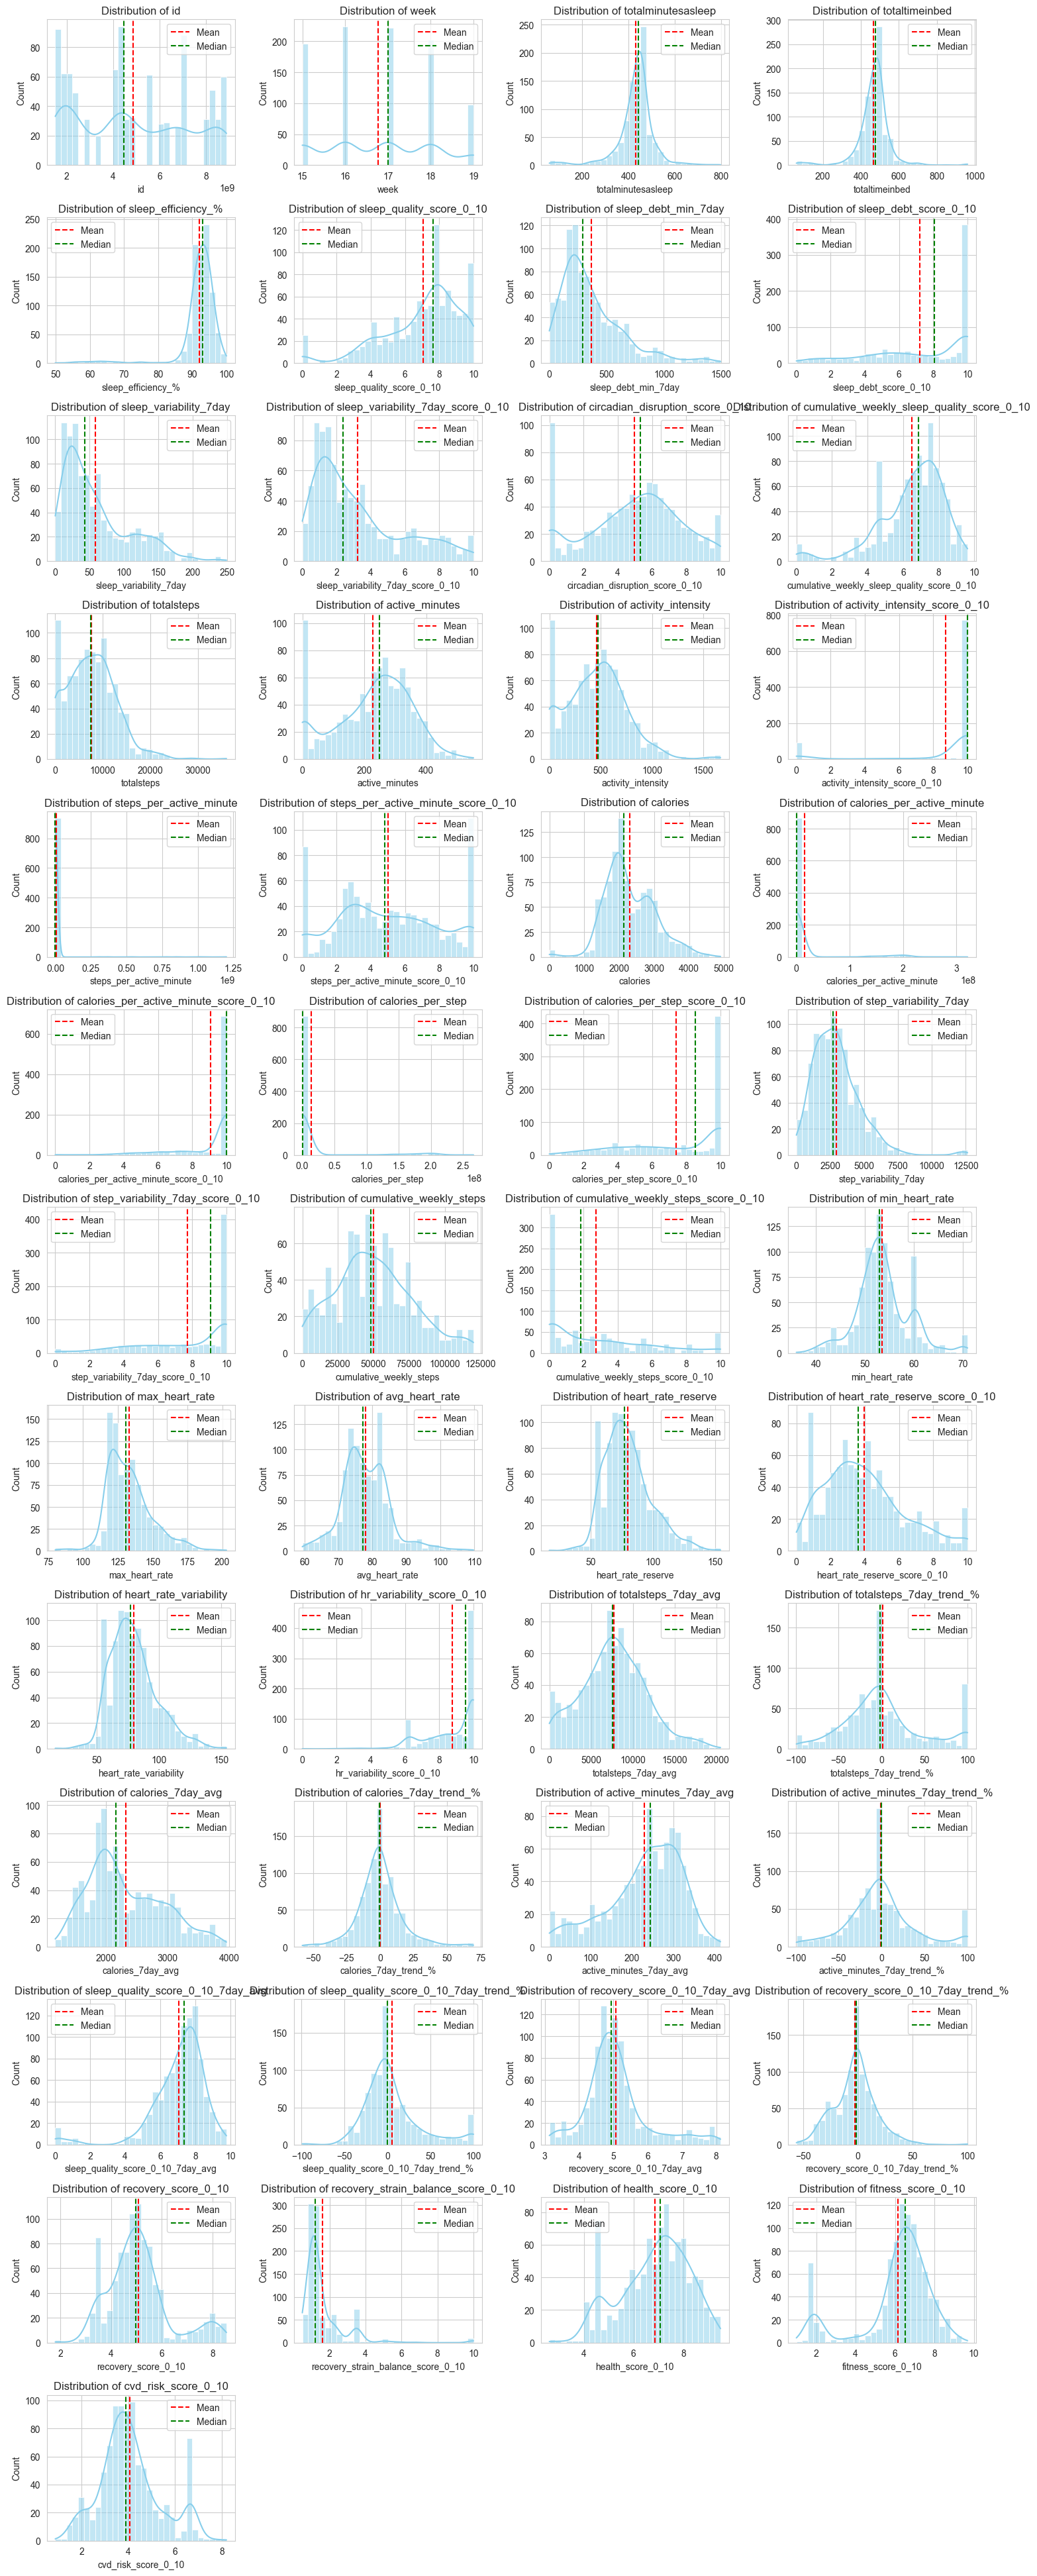


=== Outlier Analysis ===
                                             Lower Bound    Upper Bound  \
week                                           13.000000      21.000000   
totalminutesasleep                            323.260000     543.740000   
totaltimeinbed                                352.170000     587.290000   
sleep_efficiency_%                             85.309875     100.291625   
sleep_quality_score_0_10                        1.300118      13.019066   
sleep_debt_min_7day                          -280.320000     955.520000   
sleep_debt_score_0_10                          -2.283333      17.370000   
sleep_variability_7day                        -67.487903     169.792570   
sleep_variability_7day_score_0_10              -3.749328       9.432921   
circadian_disruption_score_0_10                -1.912500      12.027500   
cumulative_weekly_sleep_quality_score_0_10      2.527405      10.877976   
totalsteps                                  -6613.500000   21142.500000   

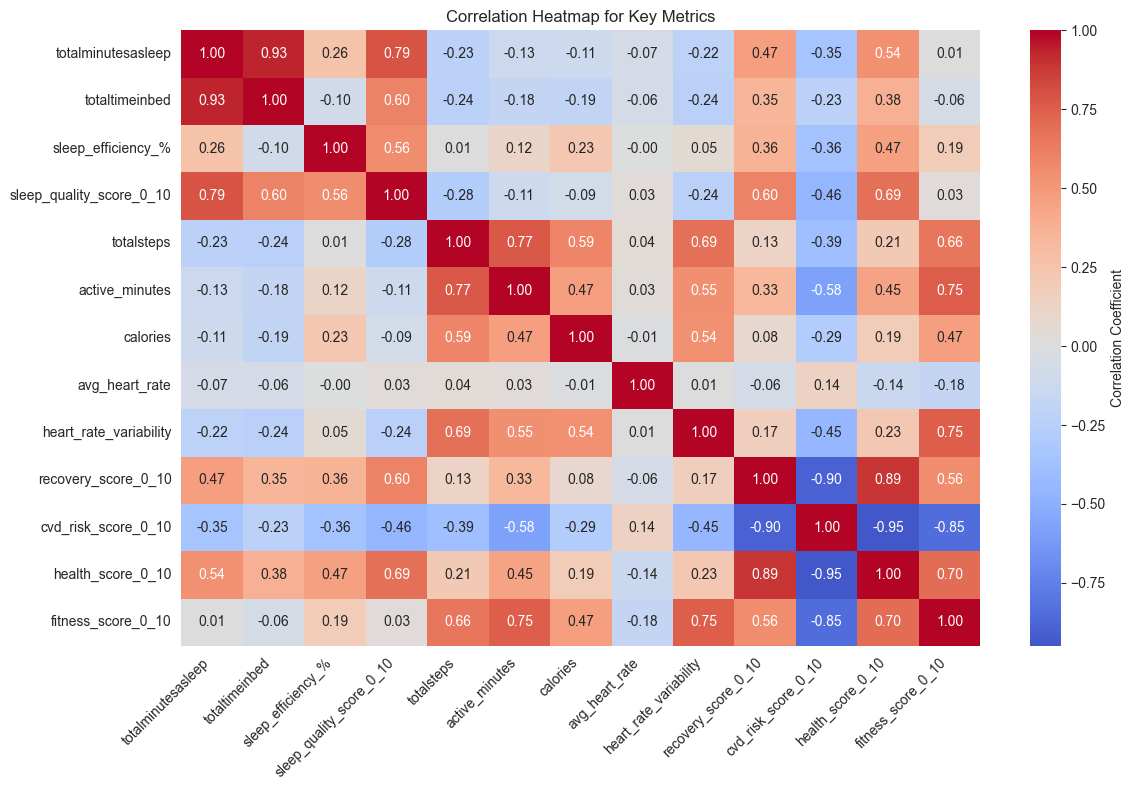


=== Composite Scores Analysis ===


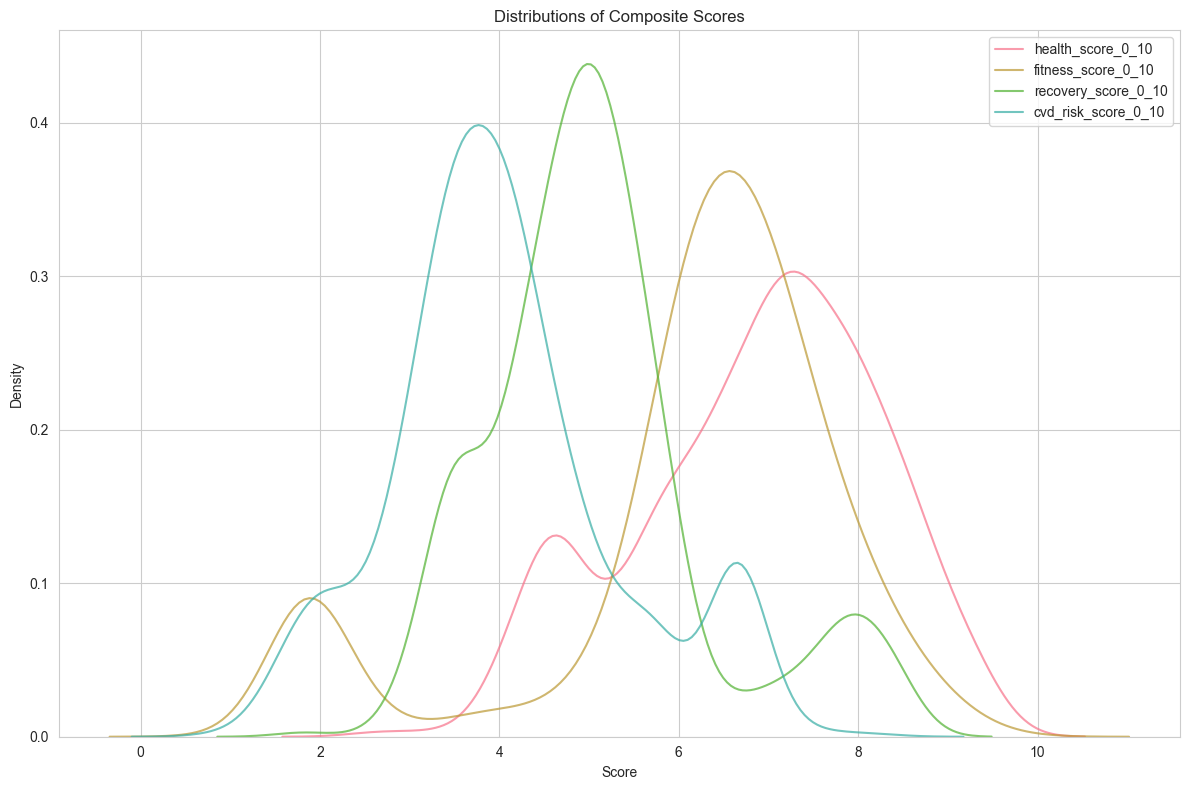

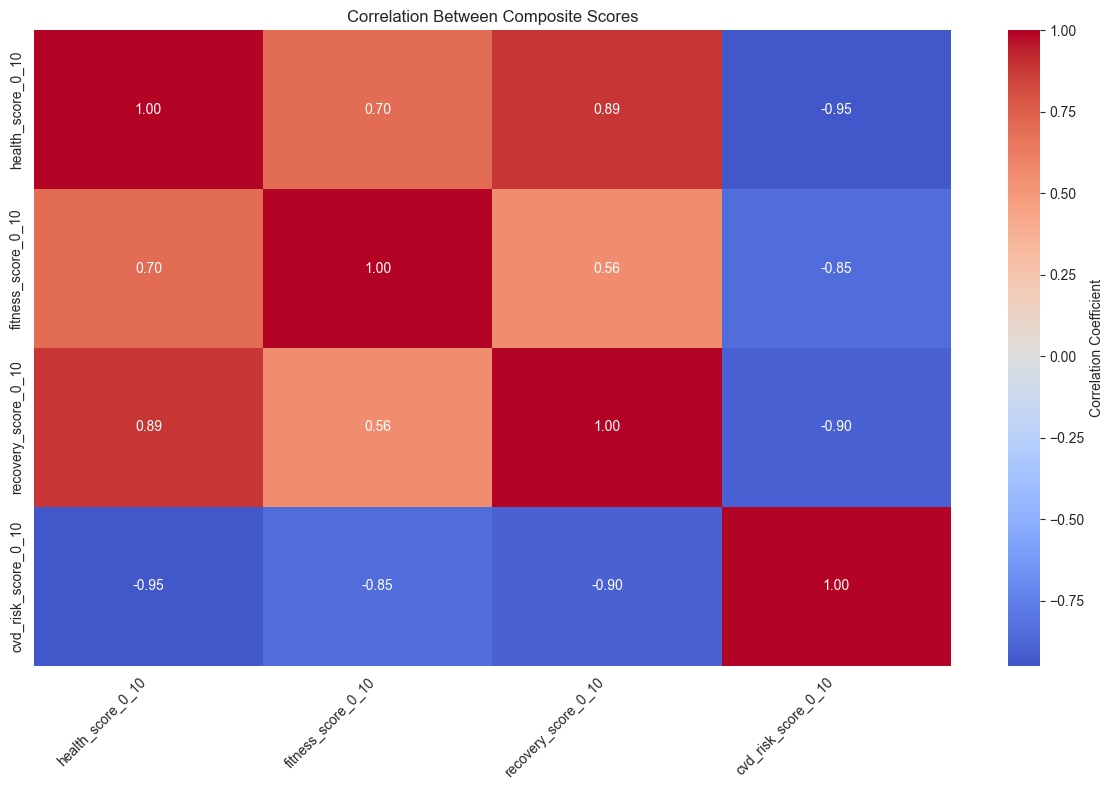

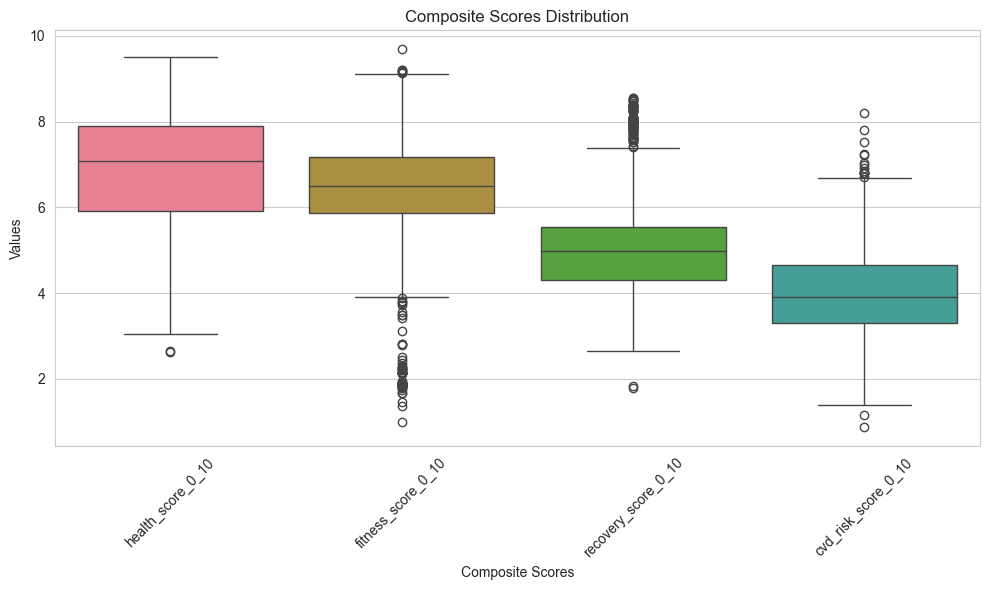


Composite Scores Summary Statistics:
       health_score_0_10  fitness_score_0_10  recovery_score_0_10  \
count         943.000000          943.000000           943.000000   
mean            6.867342            6.154535             5.084084   
std             1.358647            1.753947             1.230560   
min             2.615822            0.991436             1.792962   
25%             5.906750            5.860311             4.305000   
50%             7.072909            6.503844             4.981144   
75%             7.886516            7.167284             5.543132   
max             9.492500            9.683000             8.550000   

       cvd_risk_score_0_10  
count           943.000000  
mean              4.059803  
std               1.276782  
min               0.873400  
25%               3.296127  
50%               3.907417  
75%               4.650001  
max               8.200638  


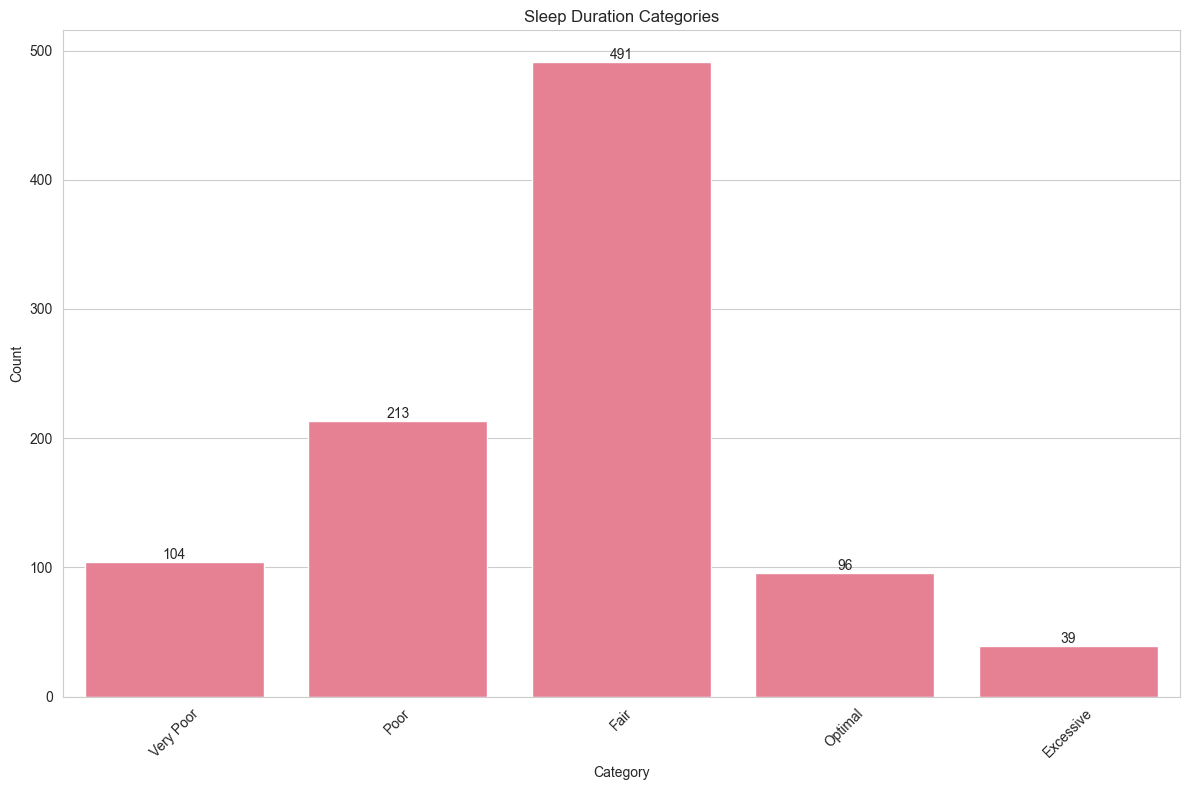

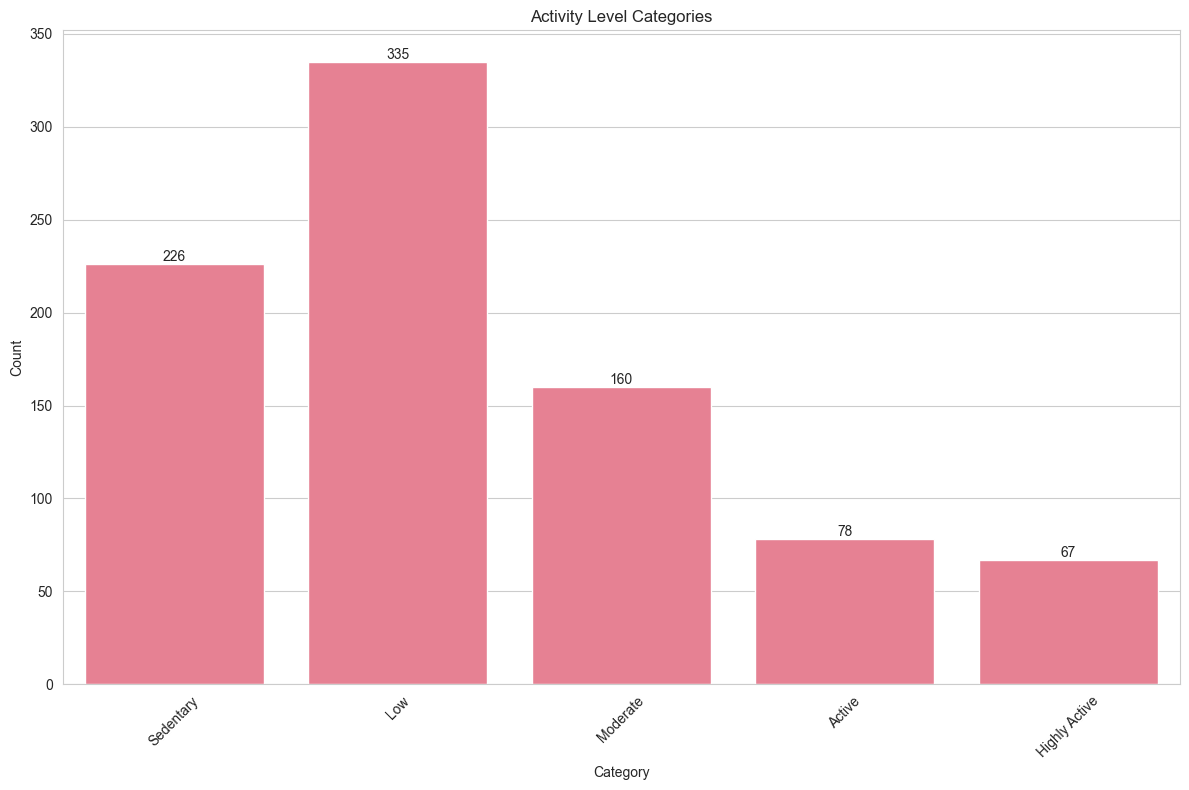

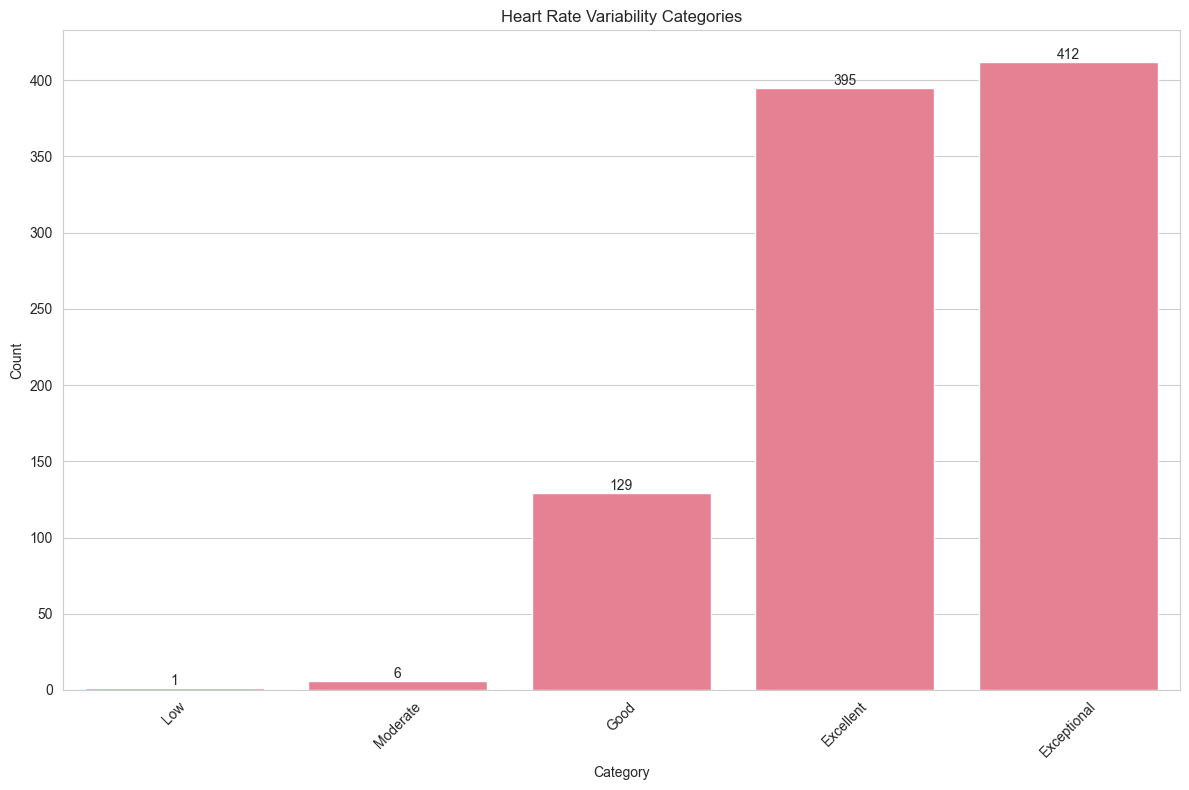

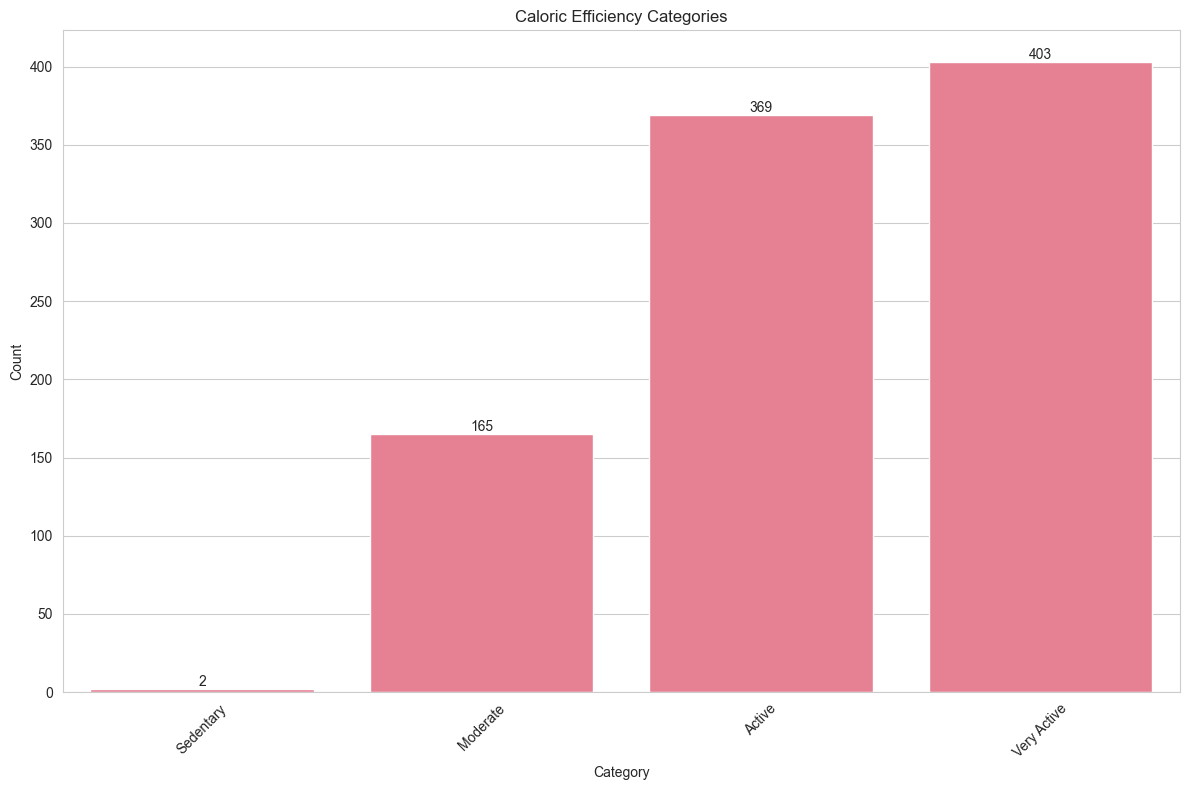


=== Key Relationships Analysis ===


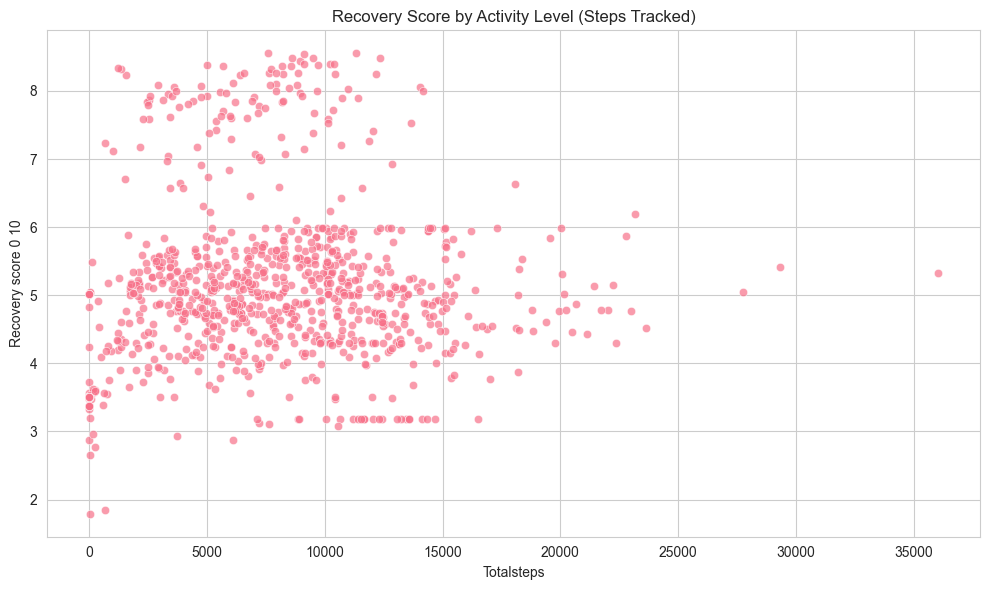

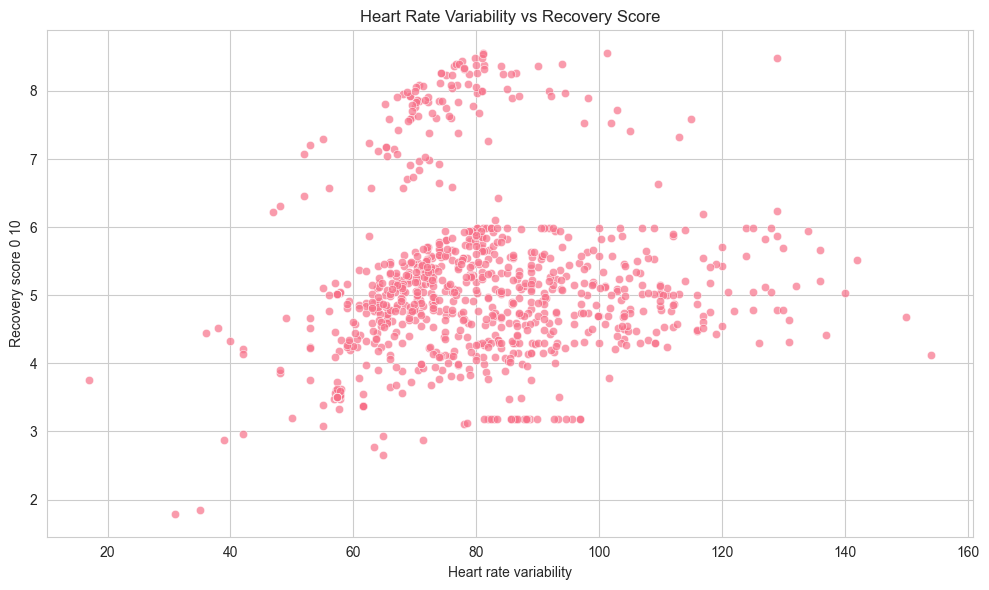

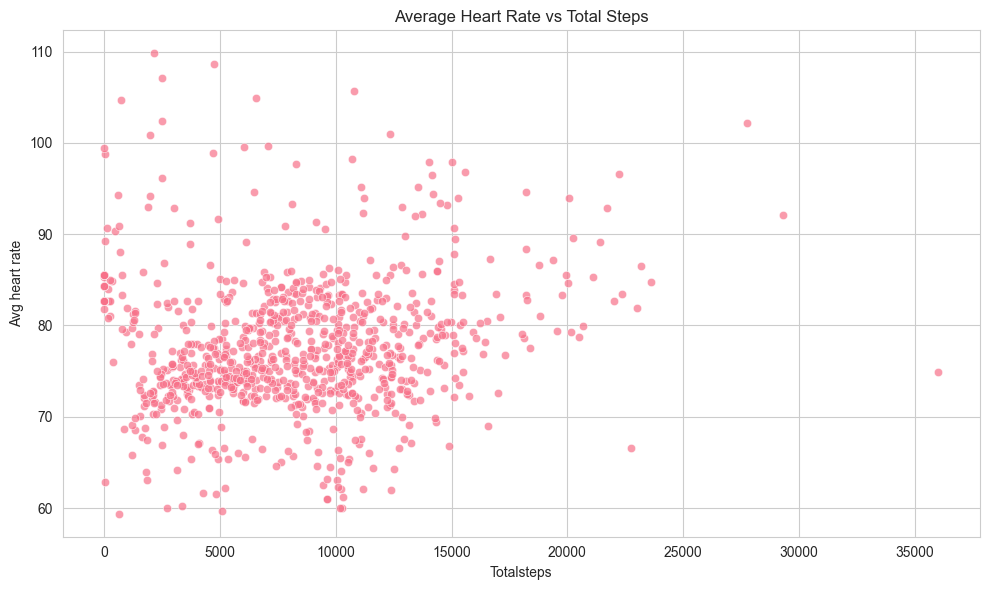

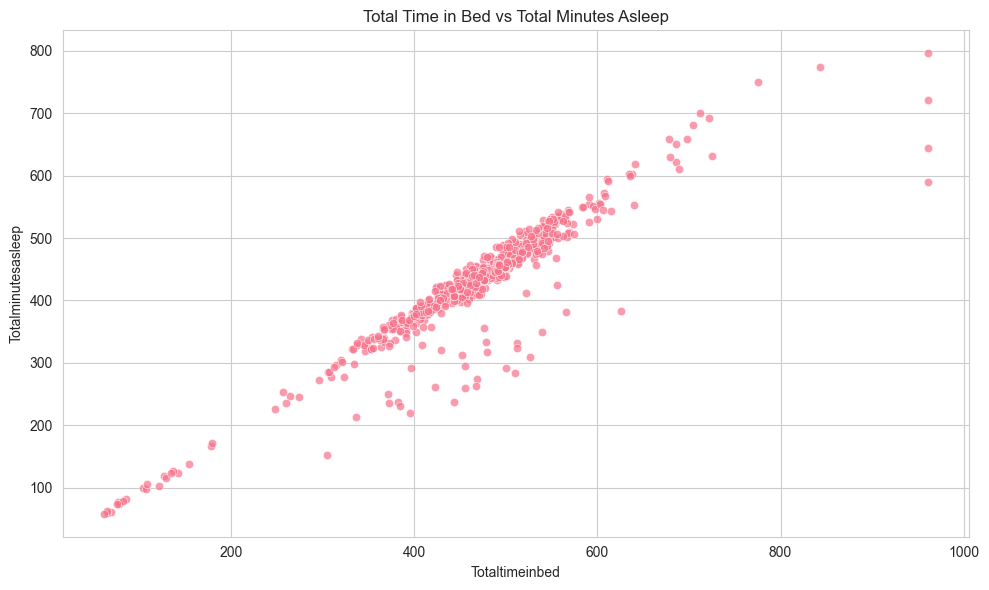

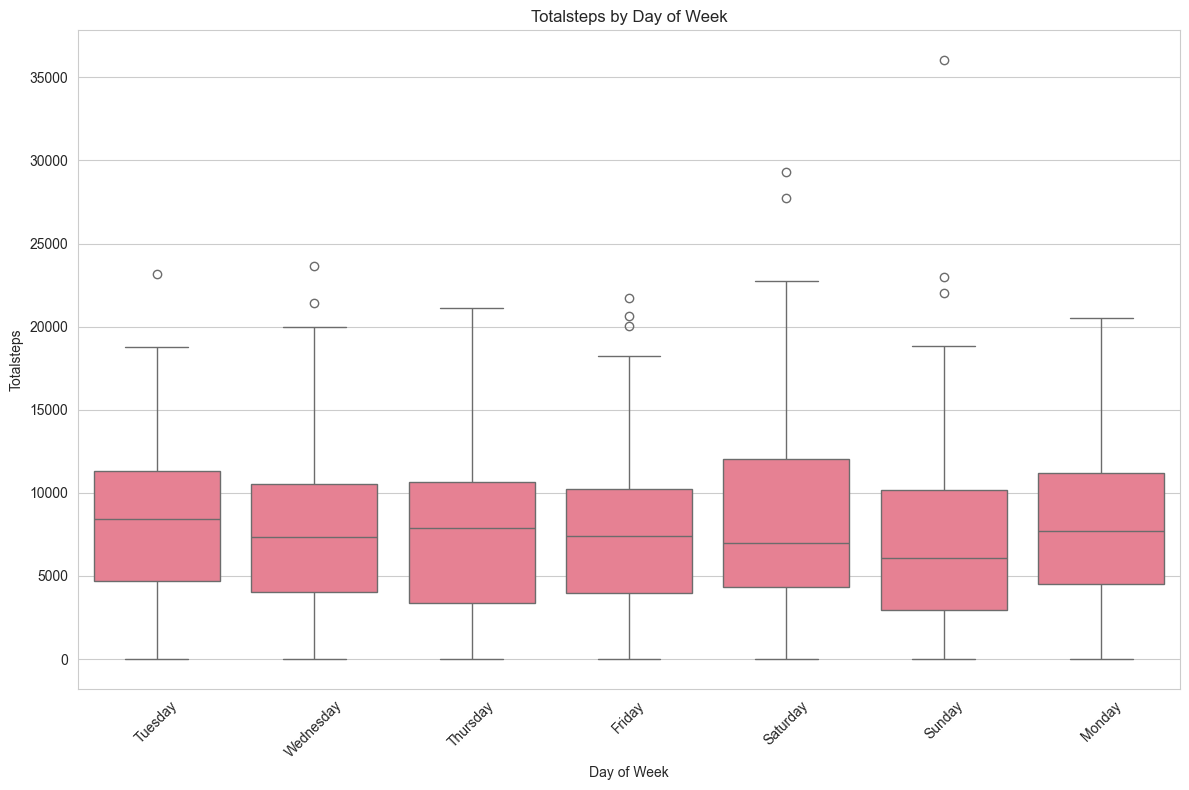

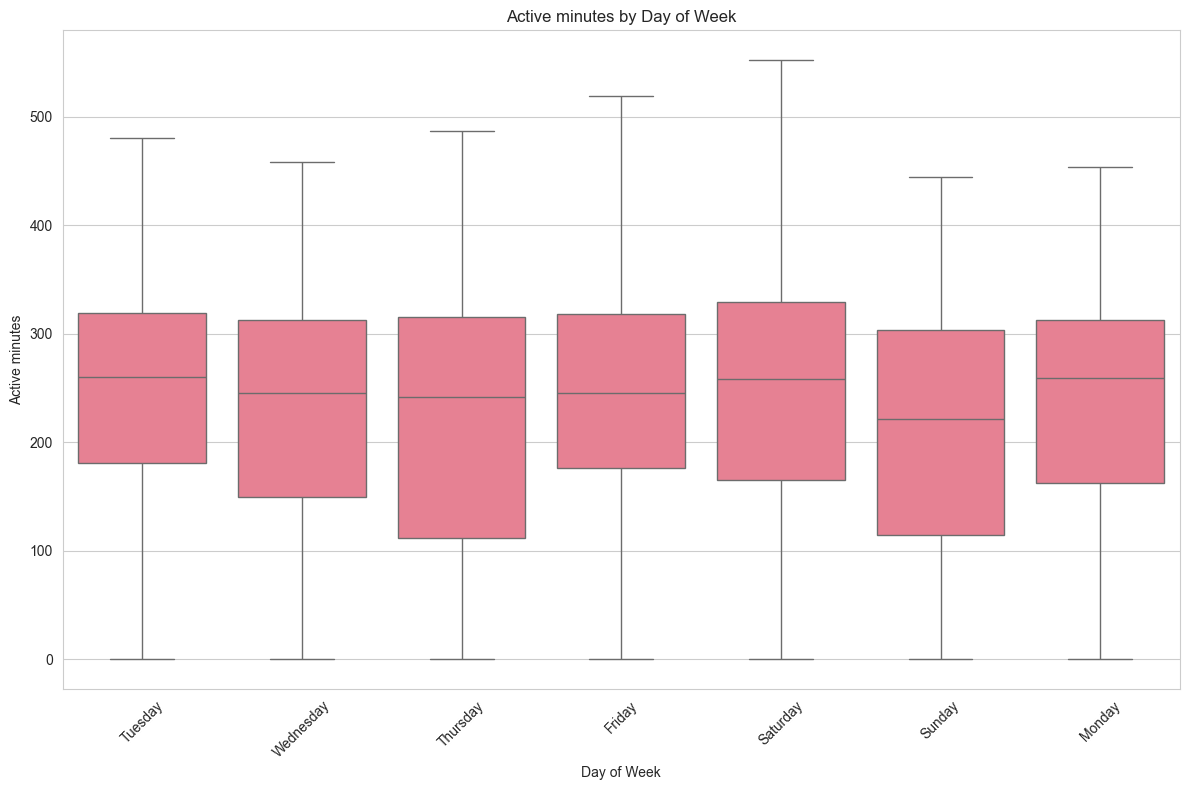

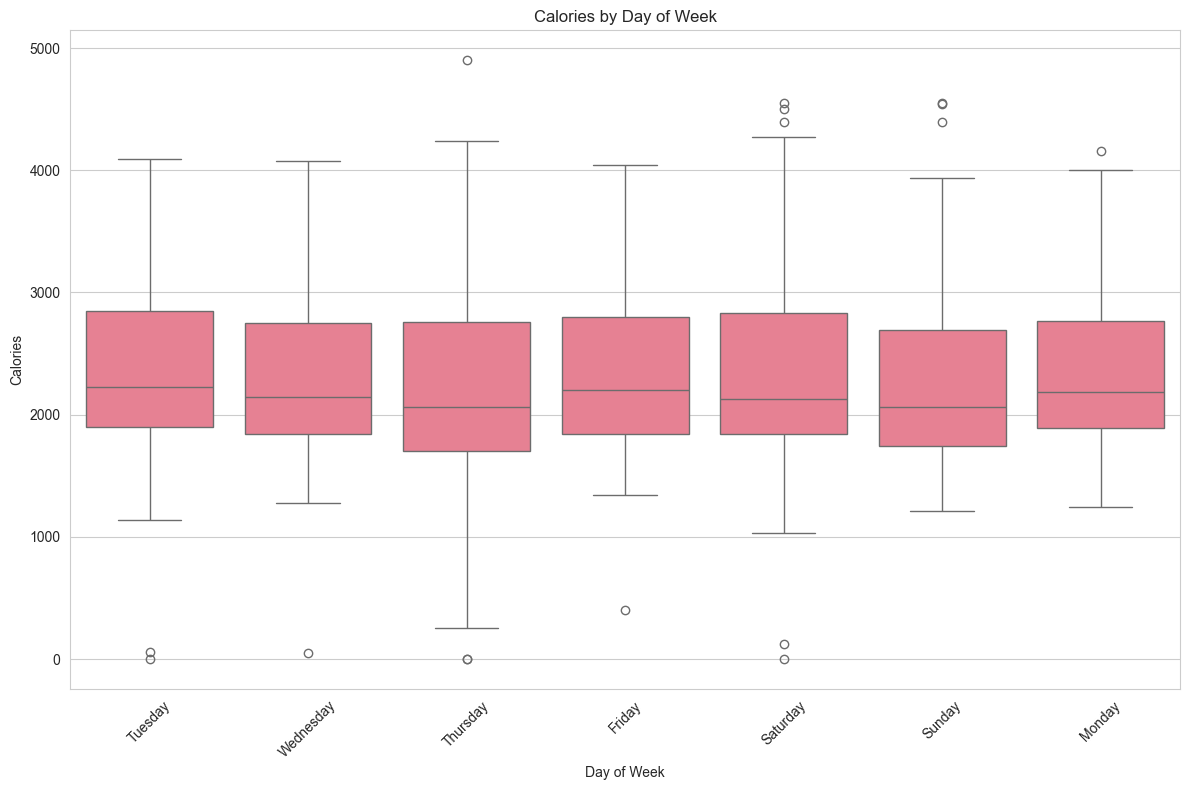

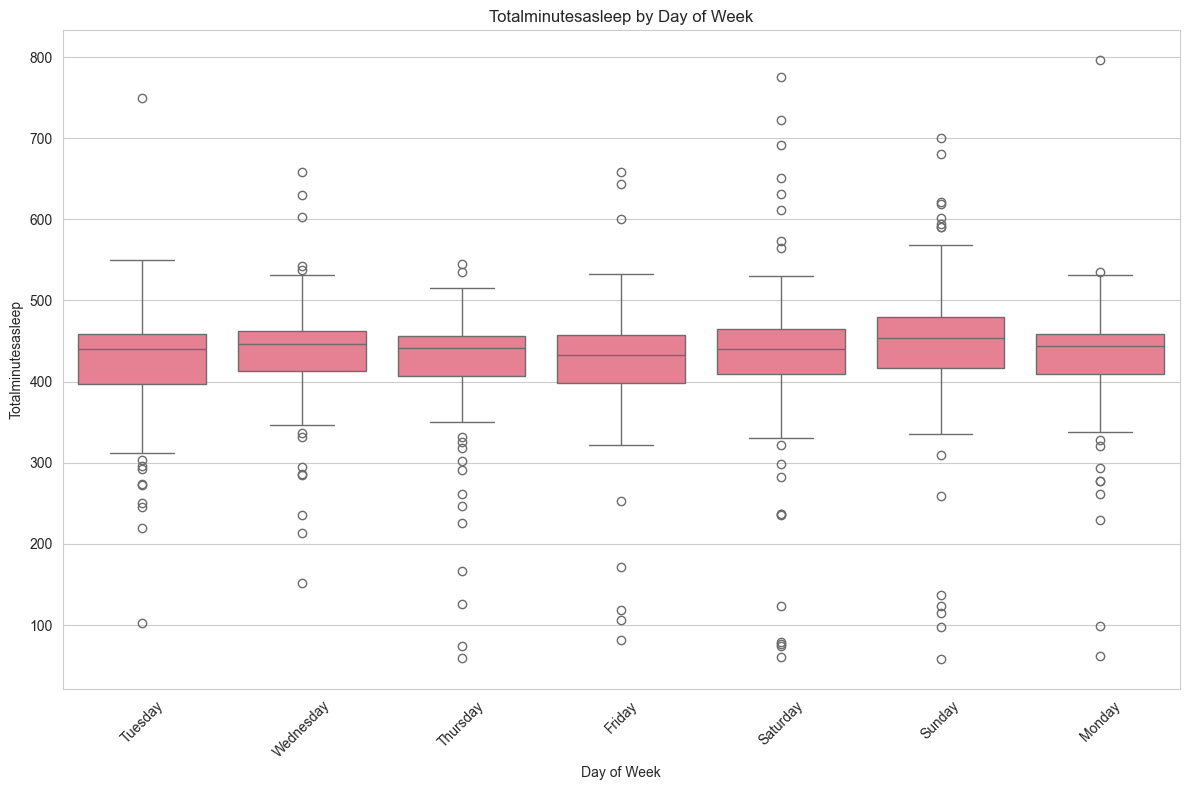

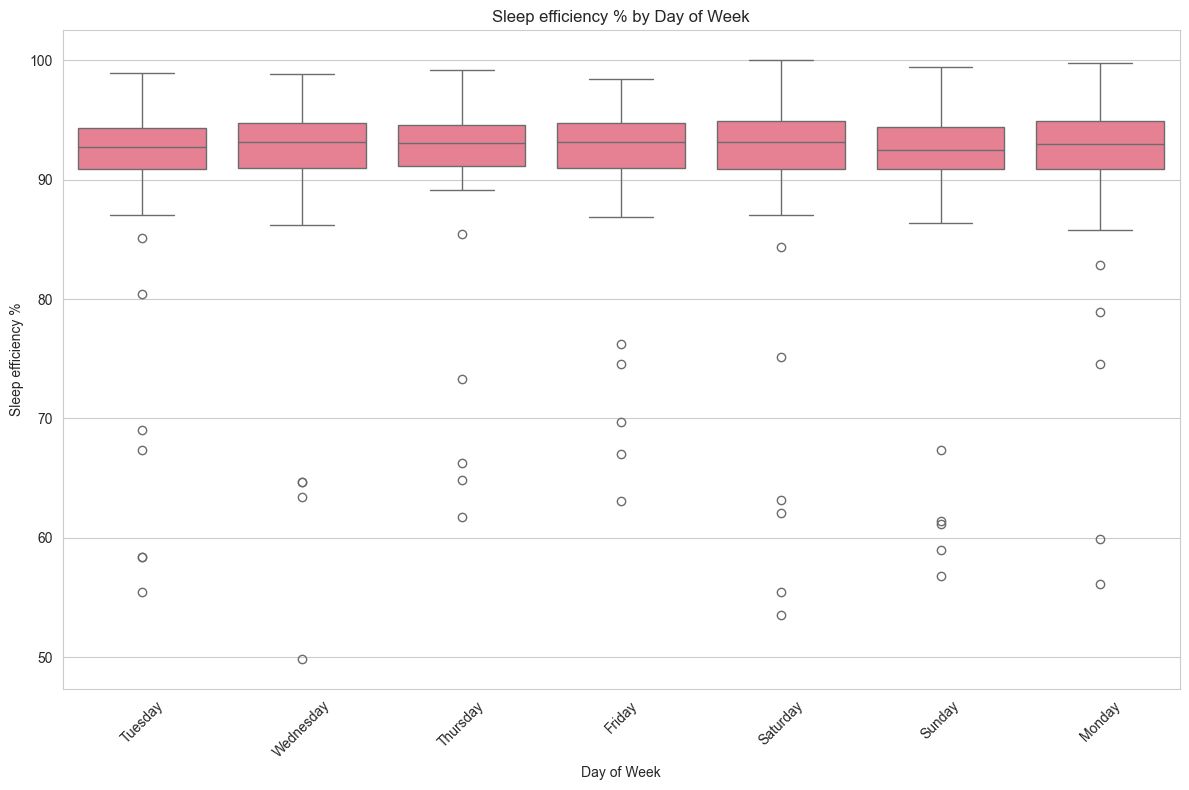

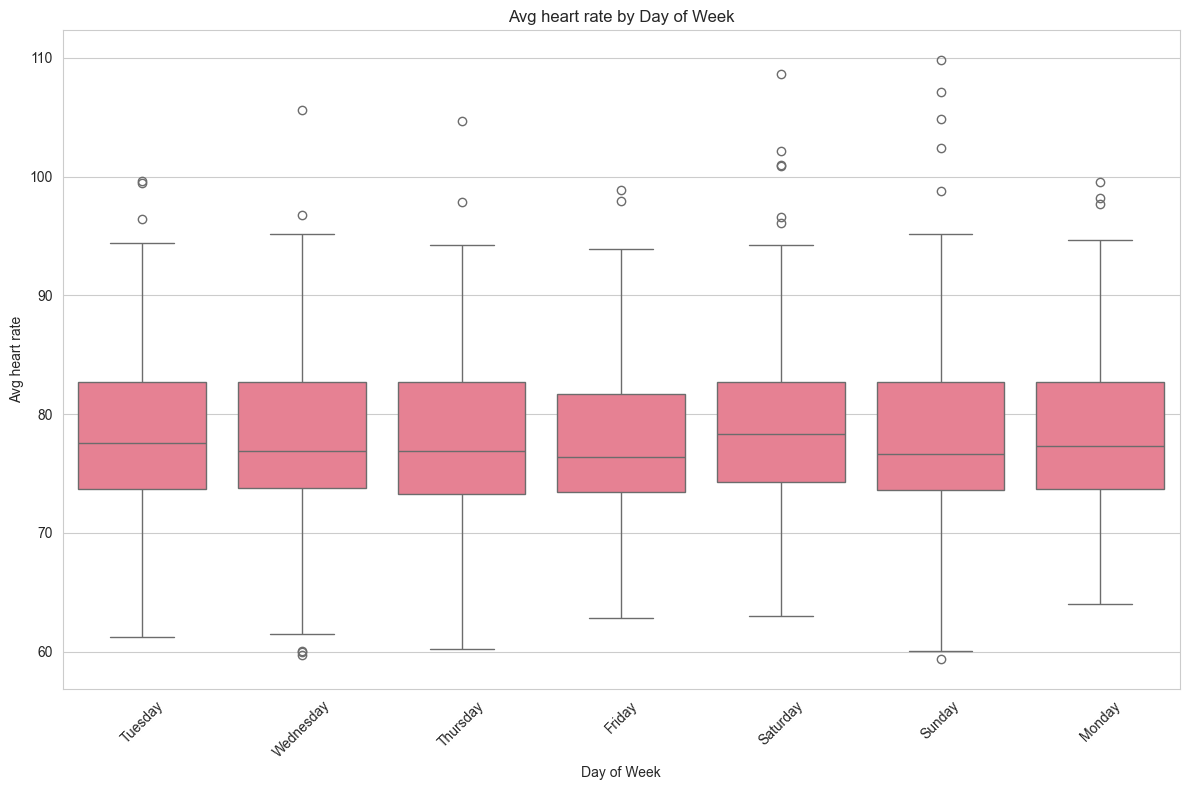

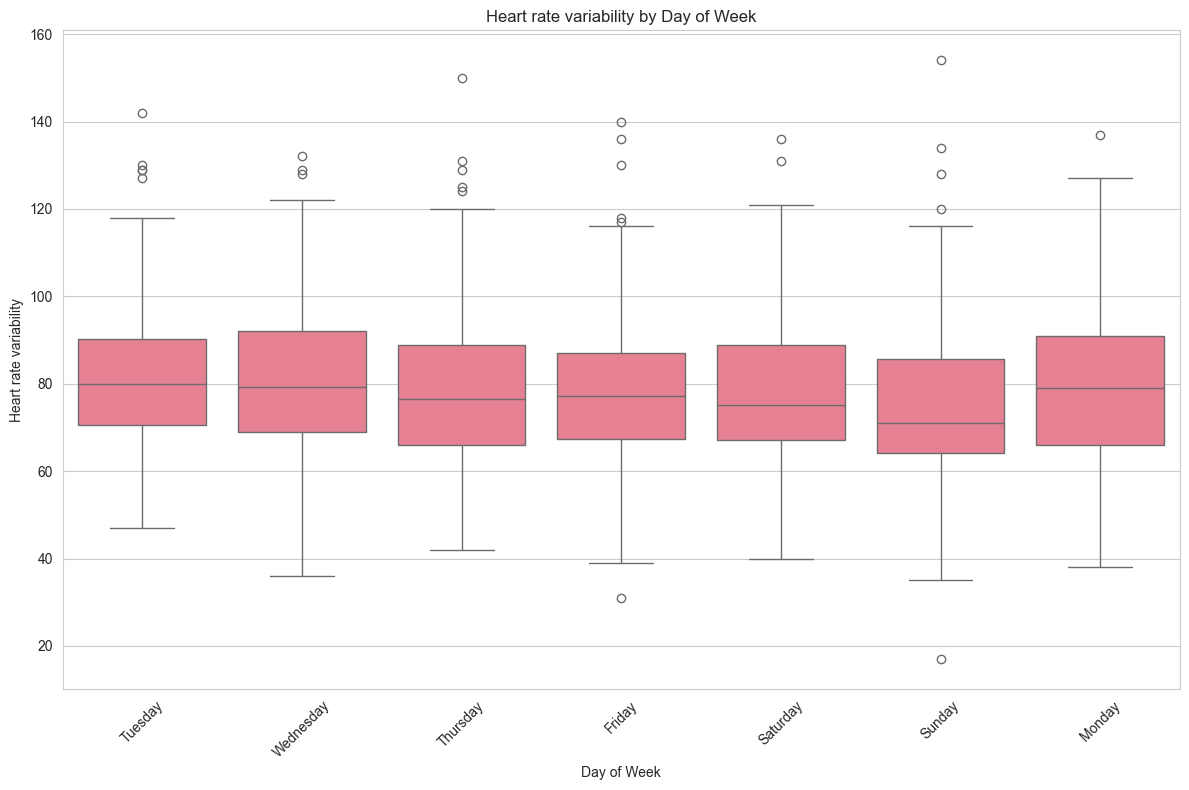

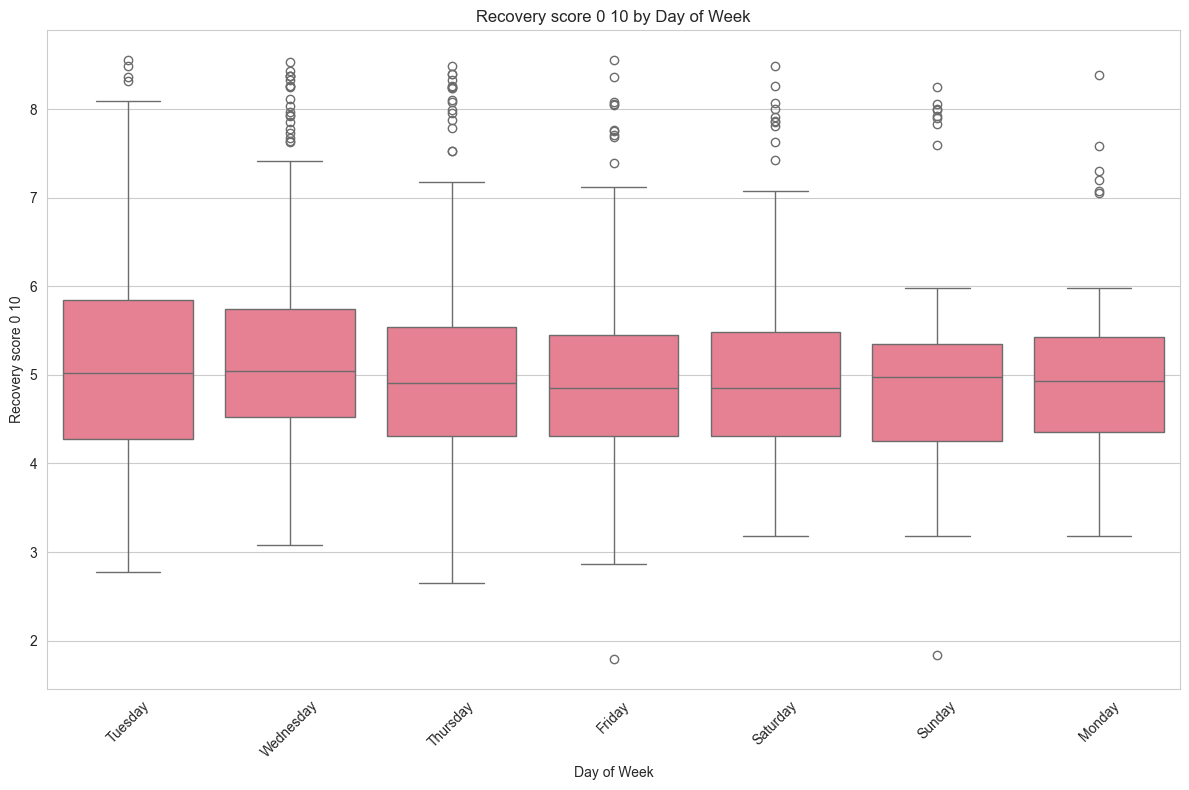

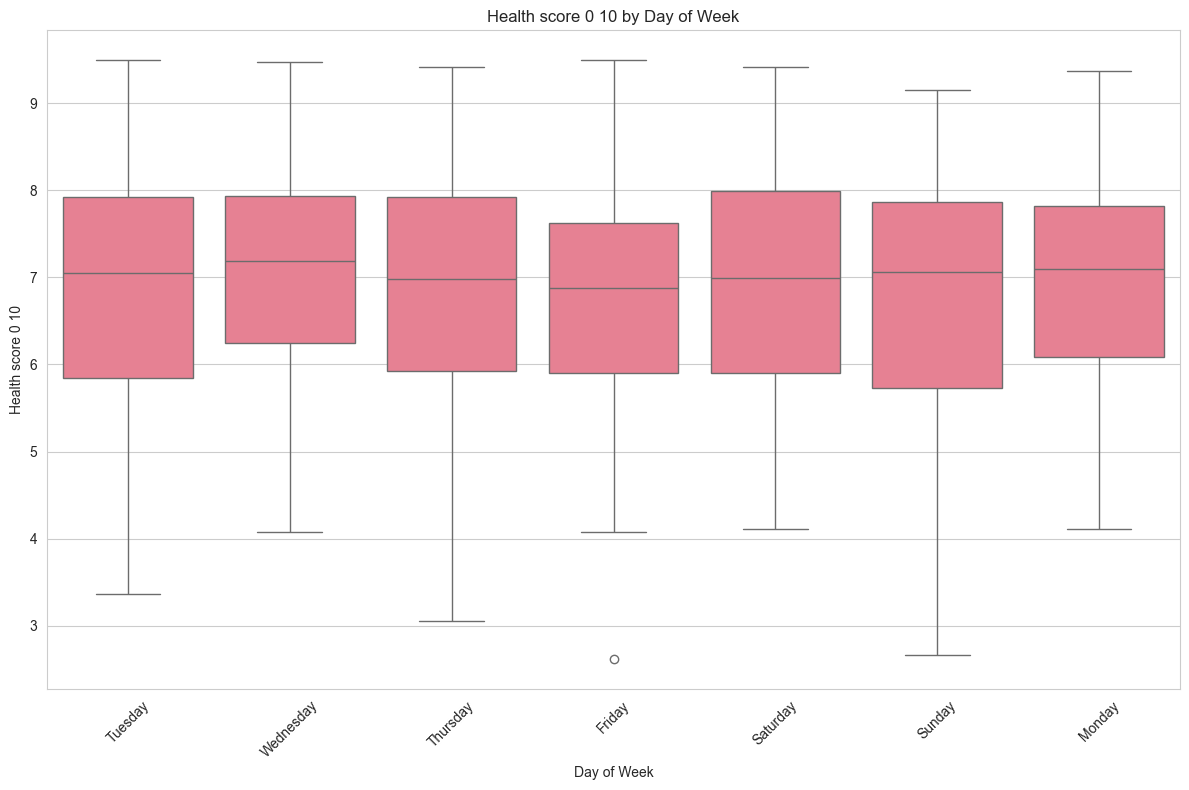

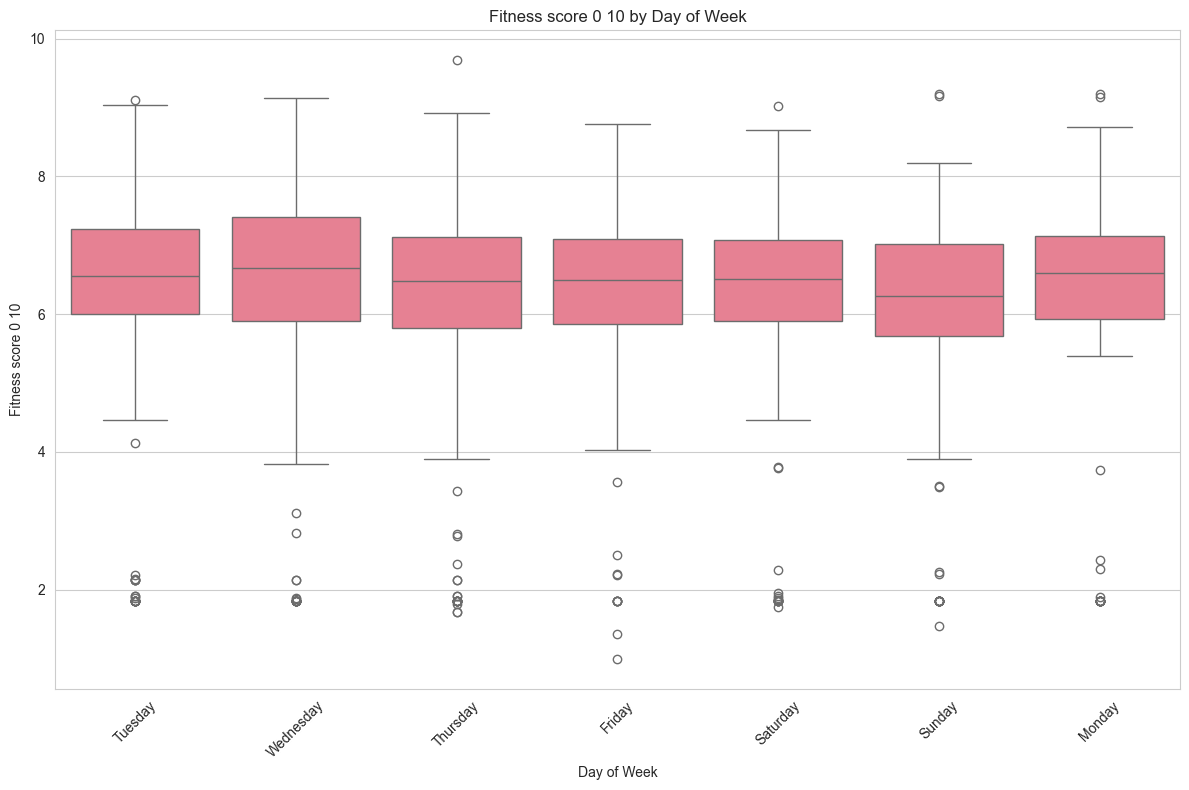

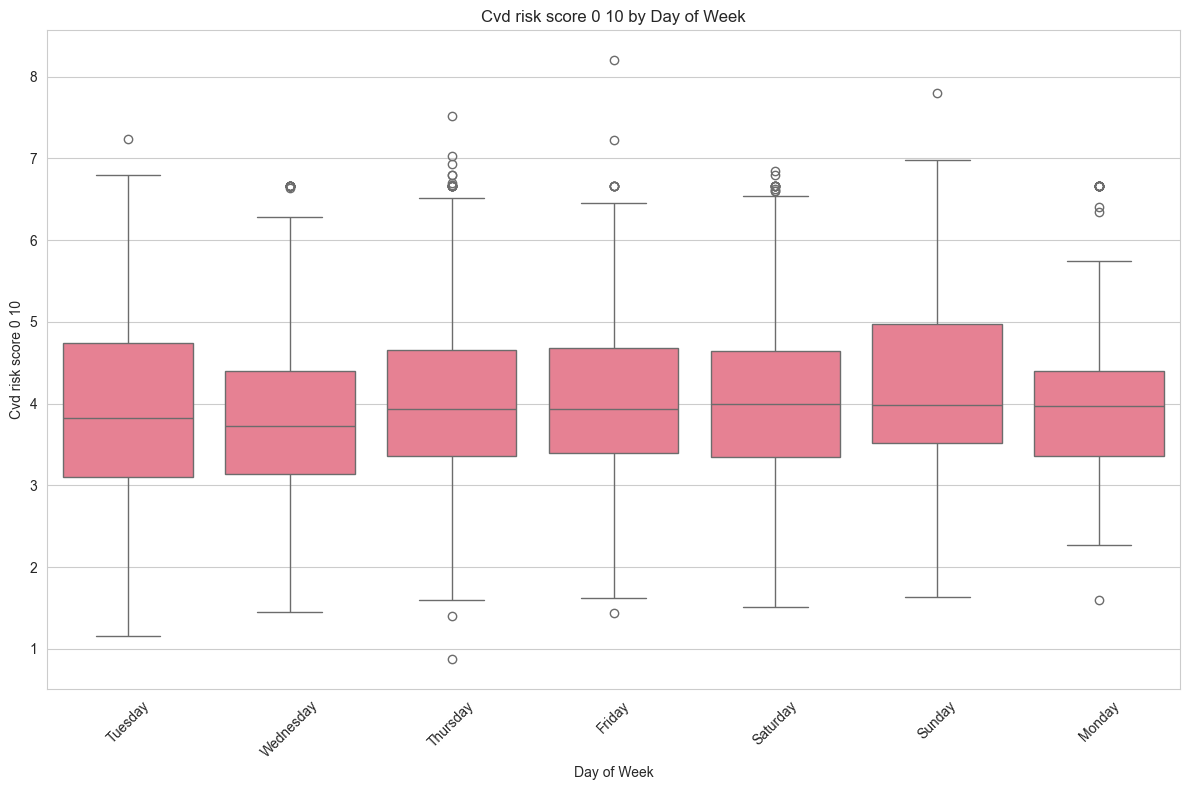

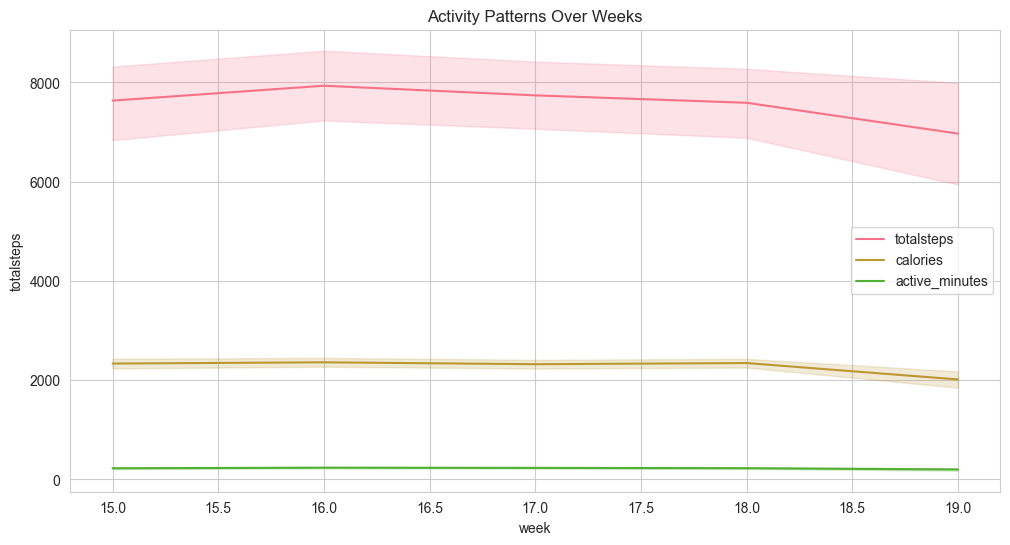

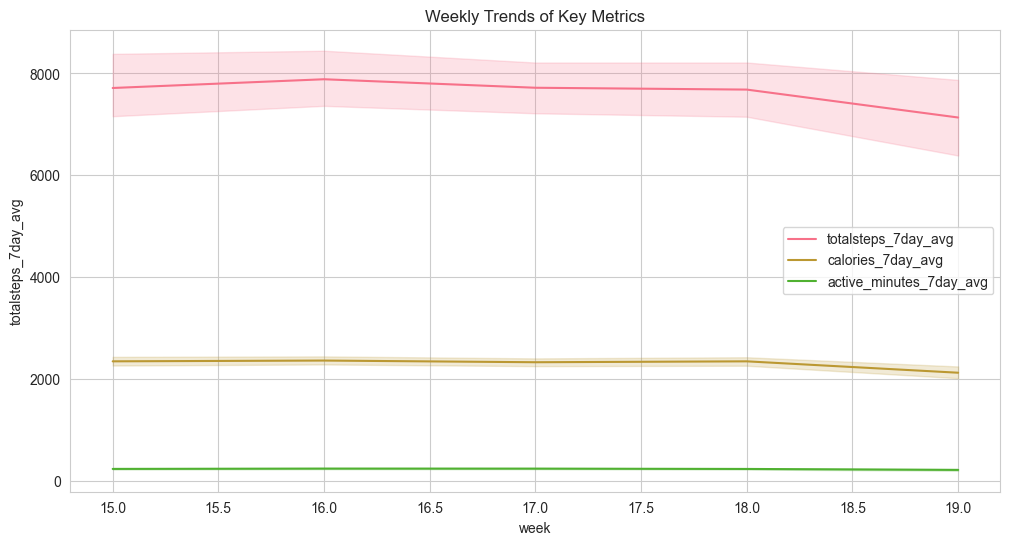


=== CVD Risk Buckets Analysis ===


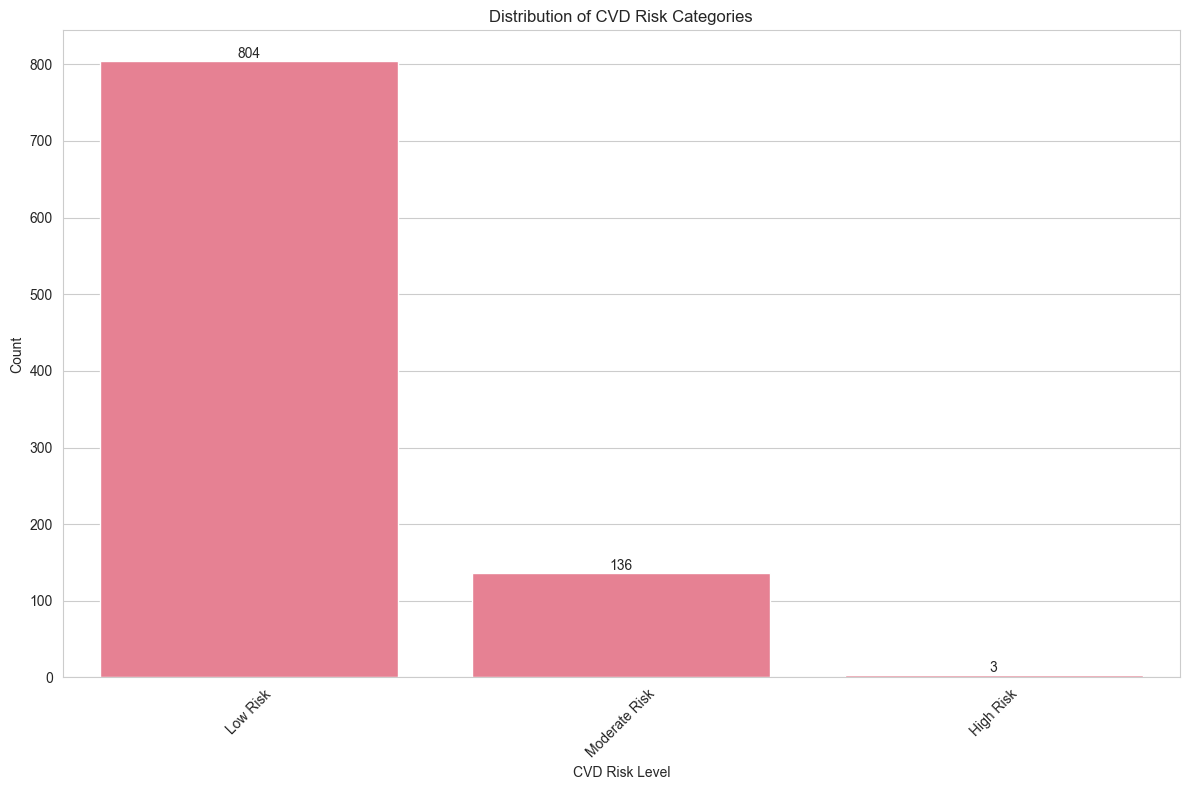

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from typing import Dict, List, Optional
import warnings
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
from src.utils.clinical_standards import ClinicalStandards
warnings.filterwarnings('ignore')

# Set plotting style
def setup_plot_style():
    """Setup consistent plotting style."""
    sns.set_style('whitegrid')
    sns.set_palette("husl")
    plt.rcParams["figure.figsize"] = [12, 8]

# Helper functions
def _plot_category_count(categories, title, xlabel="Category", ylabel="Count"):
    """
    Plot counts of categories with annotations.
    Args:
        categories (pd.Series): The categorical data to plot.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
    """
    ax = sns.countplot(x=categories)
    ax.bar_label(ax.containers[0])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def _plot_box_by_category(x, y, title, xlabel="Category", ylabel="Value"):
    """
    Plot a boxplot for a metric by categories.
    Args:
        x (pd.Series): Categorical variable.
        y (pd.Series): Numerical variable to plot.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
    """
    sns.boxplot(x=x, y=y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def _compute_iqr_bounds(series):
    """
    Compute lower and upper bounds for outlier detection using IQR.
    Args:
        series (pd.Series): Numerical data for which to compute bounds.
    Returns:
        tuple: Lower and upper bounds.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

def _plot_multiple_distributions(df, cols, title, xlabel, ylabel):
    """
    Plot multiple distributions in a single figure.
    Args:
        df (pd.DataFrame): DataFrame containing the data.
        cols (List[str]): List of numerical column names.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
    """
    plt.figure(figsize=(12, 8))
    for col in cols:
        sns.kdeplot(data=df, x=col, label=col, alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

def _plot_correlation_heatmap(df, cols, title):
    """
    Plot a correlation heatmap for specified columns.
    Args:
        df (pd.DataFrame): DataFrame containing the data.
        cols (List[str]): List of column names to analyze.
        title (str): Title of the heatmap.
    """
    corr_matrix = df[cols].corr()
    sns.heatmap(
        corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", center=0,
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 1. Basic Dataset Information
# ---------------------------
def analyze_basic_info(df):
    """Display basic dataset information."""
    print("\n=== Dataset Information ===")
    print(df.info())
    print("\nSample Data:")
    print(df.head())
    print("\nSummary of Missing Values:")
    print(df.isnull().sum())

# 2. Distribution Analysis
# -----------------------
def analyze_distributions_and_statistics(df):
    """Analyze distributions and statistical summaries."""
    numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns
    stats = df[numerical_cols].describe().T
    stats["skewness"] = df[numerical_cols].apply(lambda x: skew(x.dropna()))
    stats["kurtosis"] = df[numerical_cols].apply(lambda x: kurtosis(x.dropna()))
    print("\n=== Statistical Analysis ===")
    print(stats)

    # Distribution plots
    cols_per_row = 4
    n_rows = (len(numerical_cols) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(15, n_rows * 3))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols):
        sns.histplot(df[col], kde=True, bins=30, ax=axes[i], color="skyblue")
        axes[i].axvline(df[col].mean(), color="red", linestyle="--", label="Mean")
        axes[i].axvline(df[col].median(), color="green", linestyle="--", label="Median")
        axes[i].set_title(f"Distribution of {col}")
        axes[i].legend()
    
    for j in range(len(numerical_cols), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


# 3. Outlier Analysis
# ------------------
def analyze_outliers(df):
   """Analyze outliers in numerical columns using IQR method."""
   # Get numerical columns excluding ID
   numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns
   numerical_cols = [col for col in numerical_cols if col != 'id']
   
   # Create outlier summary dataframe
   outlier_summary = pd.DataFrame(columns=["Lower Bound", "Upper Bound", "Outliers (%)"])
   
   # Calculate outliers for each column
   for col in numerical_cols:
       lower, upper = _compute_iqr_bounds(df[col])
       outliers = df[(df[col] < lower) | (df[col] > upper)]
       outlier_pct = len(outliers) / len(df) * 100
       outlier_summary.loc[col] = [lower, upper, outlier_pct]
   
   print("\n=== Outlier Analysis ===")
   print(outlier_summary)

# 4. Key Metrics Correlation Analysis
# ---------------------------------
def analyze_correlations(df):
   """Analyze correlations between key health and activity metrics."""
   # Define key metrics to analyze
   key_columns = [
       "totalminutesasleep", "totaltimeinbed", "sleep_efficiency_%",
       "sleep_quality_score_0_10", "totalsteps", "active_minutes", "calories",
       "avg_heart_rate", "heart_rate_variability", "recovery_score_0_10",
       "cvd_risk_score_0_10", "health_score_0_10", "fitness_score_0_10"
   ]
   
   # Filter for available columns
   available_columns = [col for col in key_columns if col in df.columns]
   filtered_df = df[available_columns].copy()

   print("\n=== Correlation Analysis ===")
   _plot_correlation_heatmap(
       filtered_df, 
       available_columns,
       "Correlation Heatmap for Key Metrics"
   )

# 5. Composite Health Scores Analysis  
# ---------------------------------
def analyze_composite_scores(df):
   """Analyze relationships between composite health scores."""
   # Define composite scores
   composite_scores = [
       'health_score_0_10', 'fitness_score_0_10', 
       'recovery_score_0_10', 'cvd_risk_score_0_10'
   ]
   
   # Check data availability
   available_scores = [score for score in composite_scores if score in df.columns]
   if not available_scores:
       print("\nNo composite scores available for analysis.")
       return

   print("\n=== Composite Scores Analysis ===")
   # Plot score distributions
   _plot_multiple_distributions(
       df,
       available_scores,
       "Distributions of Composite Scores",
       "Score",
       "Density"
   )

   # Plot score correlations
   _plot_correlation_heatmap(
       df,
       available_scores,
       "Correlation Between Composite Scores"
   )

   # Distribution boxplots
   plt.figure(figsize=(10, 6))
   sns.boxplot(data=df[available_scores])
   plt.title("Composite Scores Distribution")
   plt.xlabel("Composite Scores")
   plt.ylabel("Values")
   plt.xticks(rotation=45)
   plt.tight_layout()
   plt.show()

   print("\nComposite Scores Summary Statistics:")
   print(df[composite_scores].describe())

# 6. Clinical Standards Analysis
# ----------------------------
def analyze_clinical_thresholds(df, standards):
   """Compare metrics against clinical standards and thresholds."""
   if standards is None:
       print("\nNo clinical standards provided for analysis.")
       return

   # Define metrics and their clinical categories
   clinical_metrics = {
       'totalminutesasleep': {
           'bins': [0, standards.SLEEP['duration']['poor'],
                   standards.SLEEP['duration']['minimum'],
                   standards.SLEEP['duration']['optimal'],
                   standards.SLEEP['duration']['maximum'], float('inf')],
           'labels': ['Very Poor', 'Poor', 'Fair', 'Optimal', 'Excessive'],
           'title': 'Sleep Duration Categories'
       },
       'totalsteps': {
           'bins': [0, standards.ACTIVITY['steps']['sedentary'],
                   standards.ACTIVITY['steps']['moderate'],
                   standards.ACTIVITY['steps']['active'],
                   standards.ACTIVITY['steps']['highly_active'], float('inf')],
           'labels': ['Sedentary', 'Low', 'Moderate', 'Active', 'Highly Active'],
           'title': 'Activity Level Categories'
       },
       'heart_rate_variability': {
           'bins': [0, standards.HEART_RATE['variability']['low'],
                   standards.HEART_RATE['variability']['moderate'],
                   standards.HEART_RATE['variability']['good'],
                   standards.HEART_RATE['variability']['excellent'], float('inf')],
           'labels': ['Low', 'Moderate', 'Good', 'Excellent', 'Exceptional'],
           'title': 'Heart Rate Variability Categories'
       },
       'calories_per_step': {
           'bins': [0, standards.CALORIC_EFFICIENCY['calories_per_step']['sedentary'],
                   standards.CALORIC_EFFICIENCY['calories_per_step']['moderate'],
                   standards.CALORIC_EFFICIENCY['calories_per_step']['active'], float('inf')],
           'labels': ['Sedentary', 'Moderate', 'Active', 'Very Active'],
           'title': 'Caloric Efficiency Categories'
       }
   }

   # Plot distribution for each metric against clinical standards
   for metric, config in clinical_metrics.items():
       if metric in df.columns:
           categories = pd.cut(df[metric], bins=config['bins'], labels=config['labels'])
           _plot_category_count(categories, config['title'])


# 7. Key Health Metric Relationships
# --------------------------------
def analyze_key_relationships(df, standards):
   """Analyze critical relationships between health variables."""
   print("\n=== Key Relationships Analysis ===")

   # Define key relationships to analyze
   relationships = [
       {
            'x': 'totalsteps',  
            'bins': [0, standards.ACTIVITY['steps']['sedentary'], 
                    standards.ACTIVITY['steps']['moderate'],
                    standards.ACTIVITY['steps']['active'],
                    standards.ACTIVITY['steps']['highly_active'], float('inf')],
            'labels': ['Sedentary', 'Low', 'Moderate', 'Active', 'Highly Active'],  # Labels for bins
            'hue': None, 
            'y': 'recovery_score_0_10', 
            'title': "Recovery Score by Activity Level (Steps Tracked)" 
        },
       {
           'x': 'heart_rate_variability', 
           'y': 'recovery_score_0_10',
           'hue': None,
           'title': "Heart Rate Variability vs Recovery Score"
       },
       {
           'x': 'totalsteps',
           'y': 'avg_heart_rate',
           'hue': None,
           'title': "Average Heart Rate vs Total Steps"
       },
       {
           'x': 'totaltimeinbed',
           'y': 'totalminutesasleep',
           'hue': None,
           'title': "Total Time in Bed vs Total Minutes Asleep"
       }   
   ]

   # Plot each relationship
   for rel in relationships:
       plt.figure(figsize=(10, 6))
       hue = None
       if rel['hue'] and rel['hue'] in df.columns:
           hue = pd.cut(df[rel['hue']], bins=rel['hue_bins'], labels=rel['hue_labels'])

       sns.scatterplot(data=df, x=rel['x'], y=rel['y'], hue=hue, alpha=0.7)
       plt.title(rel['title'])
       plt.xlabel(rel['x'].replace("_", " ").capitalize())
       plt.ylabel(rel['y'].replace("_", " ").capitalize())
       if hue is not None:
           plt.legend(title=rel['hue'].replace("_", " ").capitalize(), 
                     bbox_to_anchor=(1.05, 1), loc="upper left")
       plt.tight_layout()
       plt.show()

# 8. Daily Pattern Analysis
# ------------------------
def analyze_group_patterns(df):
   """Analyze patterns across days of the week."""
   if "day_of_week" not in df.columns:
       print("\nDay of Week column is missing.")
       return

   # Key metrics to analyze by day
   key_columns = [
       "totalsteps", "active_minutes", "calories", "totalminutesasleep",
       "sleep_efficiency_%", "avg_heart_rate", "heart_rate_variability",
       "recovery_score_0_10", "health_score_0_10", "fitness_score_0_10", 
       "cvd_risk_score_0_10"
   ]

   # Create boxplots for each metric by day
   for metric in key_columns:
       if metric in df.columns:
           _plot_box_by_category(
               x=df["day_of_week"], 
               y=df[metric],
               title=f"{metric.replace('_', ' ').capitalize()} by Day of Week",
               xlabel="Day of Week",
               ylabel=metric.replace("_", " ").capitalize()
           )

# 9. Activity Pattern Analysis
# --------------------------
def analyze_activity_patterns(df):
   """Analyze activity patterns over time."""
   activity_metrics = ["totalsteps", "calories", "active_minutes"]
   plt.figure(figsize=(12, 6))
   for metric in activity_metrics:
       if metric in df.columns:
           sns.lineplot(data=df, x="week", y=metric, label=metric)
   plt.title("Activity Patterns Over Weeks")
   plt.legend()
   plt.show()

# 10. Weekly Trend Analysis
# ----------------------
def analyze_weekly_trends(df):
   """Analyze weekly aggregated trends."""
   metrics = ['totalsteps_7day_avg', 'calories_7day_avg', 'active_minutes_7day_avg']
   available_metrics = [m for m in metrics if m in df.columns]
   
   if available_metrics:
       plt.figure(figsize=(12, 6))
       for metric in available_metrics:
           sns.lineplot(data=df, x="week", y=metric, label=metric)
       plt.title("Weekly Trends of Key Metrics")
       plt.legend()
       plt.show()

# 11. CVD Risk Analysis
# -------------------
def analyze_cvd_risk_buckets(df):
   """Analyze cardiovascular risk distributions."""
   if 'cvd_risk_category' in df.columns:
       print("\n=== CVD Risk Buckets Analysis ===")
       _plot_category_count(
           categories=df['cvd_risk_category'],
           title="Distribution of CVD Risk Categories",
           xlabel="CVD Risk Level",
           ylabel="Count"
       )

# Preform comprehensive eda using all defined functions

def perform_comprehensive_eda(df, standards=None):
    """
    Perform comprehensive EDA by executing multiple analysis functions.
    Args:
        df (pd.DataFrame): DataFrame to analyze.
        standards (Optional[object]): Clinical standards for thresholds.
    """
    setup_plot_style()
    analyze_basic_info(df)
    analyze_distributions_and_statistics(df)
    analyze_outliers(df)
    analyze_correlations(df)
    analyze_composite_scores(df)
    if standards:
        analyze_clinical_thresholds(df, standards)
        analyze_key_relationships(df, standards)
    analyze_group_patterns(df)
    analyze_activity_patterns(df)
    analyze_weekly_trends(df)
    analyze_cvd_risk_buckets(df)

# define data path for processed data
data_path = "../data/processed/df_processed.csv"
df_processed = pd.read_csv(data_path)
standards = ClinicalStandards()

# Run EDA
perform_comprehensive_eda(df_processed, standards)

